# NCI60 using RSKC

In [1]:
library("ISLR") 
library("evaluomeR")
library("dplyr")
library("caret")
library("MLmetrics")
library("ggplot2")
library("ggrepel")
library("reshape2")

options(scipen=10)
options(repr.plot.width=12, repr.plot.height=12)

Cargando paquete requerido: SummarizedExperiment

Cargando paquete requerido: MatrixGenerics

Cargando paquete requerido: matrixStats


Adjuntando el paquete: 'MatrixGenerics'


The following objects are masked from 'package:matrixStats':

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowCumsums, rowDiffs, rowIQRDiffs, rowIQRs, rowLogSumExps,
    rowMadDiffs, rowMads, rowMaxs, rowMeans2, rowMedians, rowMins,
    rowOrderStats, rowProds, rowQuantiles,

# Table of contents
* [Dataset](#dataset)
    * [Top 200](#top)
* [evaluomeR - optimal $k$ analysis](#evaluomer)
    * [Stability plotting](#evaluomeR_stab_plot)
    * [Quality plotting](#evaluomeR_qual_plot)
* [PCA](#pca)
* [Sensitivity](#sensitivity)
* [CER](#cer)

# Dataset <a class="anchor" id="dataset"></a>

In [2]:
seed = 13606
k.range = c(3,10)
cbi = "kmeans"
alpha = 0

In [3]:
nci60 = as.data.frame(NCI60$data)
head(nci60)

,1,2,3,4,5,6,7,8,9,10,⋯,6821,6822,6823,6824,6825,6826,6827,6828,6829,6830
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
V1,0.300000,1.180000,0.550000,1.140000,-0.265000,-7.000000e-02,0.350000,-0.315000,-0.45000000,-0.65498050,⋯,-0.9900195,0.000000,0.030000,-0.175000,0.6299805,-0.030000,0.0000000,0.280000,-0.340000,-1.930000
V2,0.679961,1.289961,0.169961,0.379961,0.464961,5.799610e-01,0.699961,0.724961,-0.04003899,-0.28501950,⋯,-0.2700585,-0.300039,-0.250039,-0.535039,0.1099415,-0.860039,-1.2500490,-0.770039,-0.390039,-2.000039
V3,0.940000,-0.040000,-0.170000,-0.040000,-0.605000,0.000000e+00,0.090000,0.645000,0.43000000,0.47501950,⋯,0.3199805,0.120000,-0.740000,-0.595000,-0.2700195,-0.150000,0.0000000,-0.120000,-0.410000,0.000000
V4,0.280000,-0.310000,0.680000,-0.810000,0.625000,-1.387779e-17,0.170000,0.245000,0.02000000,0.09501949,⋯,-1.2400200,-0.110000,-0.160000,0.095000,-0.3500195,-0.300000,-1.1500100,1.090000,-0.260000,-1.100000
V5,0.485000,-0.465000,0.395000,0.905000,0.200000,-5.000000e-03,0.085000,0.110000,0.23500000,1.49001949,⋯,0.5549805,-0.775000,-0.515000,-0.320000,0.6349805,0.605000,0.0000000,0.745000,0.425000,0.145000
V6,0.310000,-0.030000,-0.100000,-0.460000,-0.205000,-5.400000e-01,-0.640000,-0.585000,-0.77000000,-0.24498050,⋯,-0.5900195,0.000000,-0.740000,-2.095000,-1.3900200,-0.400000,0.6999902,0.290000,0.550000,0.000000


There are 14 types of classes within the dataset: **CNS**, **RENAL**, **BREAST**, **NSCLC**, **UNKNOWN**, **OVARIAN**, **MELANOMA**, **PROSTATE**, **LEUKEMIA**, **K562B-repro**, **K562A-repro**, **COLON**, **MCF7A-repro** and **MCF7D-repro**:

In [4]:
as.vector(unlist(unique(NCI60$labs)))

[1] "CNS"         "RENAL"       "BREAST"      "NSCLC"       "UNKNOWN"    
 [6] "OVARIAN"     "MELANOMA"    "PROSTATE"    "LEUKEMIA"    "K562B-repro"
[11] "K562A-repro" "COLON"       "MCF7A-repro" "MCF7D-repro"

Here, we prepare the NCI60 dataset for the analysis:

- We add a column named `Description` containing the class (category) of each row
- Due to their small class size, we remove the two prostate cell lines and the unknown cell line, "PROSTATE" and "UNKNOWN" entires respectively.

In [5]:
nci60["Description"] = rownames(nci60)
nci60 = nci60[ , c("Description", names(nci60)[names(nci60) != "Description"])]
nci60["Description"] = NCI60$labs
nci60 = nci60[!grepl("UNKNOWN", nci60$Description),] # Remove UNKNOWN
nci60 = nci60[!grepl("PROSTATE", nci60$Description),] # Remove PROSTATE

In [6]:
head(nci60)

,Description,1,2,3,4,5,6,7,8,9,⋯,6821,6822,6823,6824,6825,6826,6827,6828,6829,6830
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
V1,CNS,0.300000,1.180000,0.550000,1.140000,-0.265000,-7.000000e-02,0.350000,-0.315000,-0.45000000,⋯,-0.9900195,0.000000,0.030000,-0.175000,0.6299805,-0.030000,0.0000000,0.280000,-0.340000,-1.930000
V2,CNS,0.679961,1.289961,0.169961,0.379961,0.464961,5.799610e-01,0.699961,0.724961,-0.04003899,⋯,-0.2700585,-0.300039,-0.250039,-0.535039,0.1099415,-0.860039,-1.2500490,-0.770039,-0.390039,-2.000039
V3,CNS,0.940000,-0.040000,-0.170000,-0.040000,-0.605000,0.000000e+00,0.090000,0.645000,0.43000000,⋯,0.3199805,0.120000,-0.740000,-0.595000,-0.2700195,-0.150000,0.0000000,-0.120000,-0.410000,0.000000
V4,RENAL,0.280000,-0.310000,0.680000,-0.810000,0.625000,-1.387779e-17,0.170000,0.245000,0.02000000,⋯,-1.2400200,-0.110000,-0.160000,0.095000,-0.3500195,-0.300000,-1.1500100,1.090000,-0.260000,-1.100000
V5,BREAST,0.485000,-0.465000,0.395000,0.905000,0.200000,-5.000000e-03,0.085000,0.110000,0.23500000,⋯,0.5549805,-0.775000,-0.515000,-0.320000,0.6349805,0.605000,0.0000000,0.745000,0.425000,0.145000
V6,CNS,0.310000,-0.030000,-0.100000,-0.460000,-0.205000,-5.400000e-01,-0.640000,-0.585000,-0.77000000,⋯,-0.5900195,0.000000,-0.740000,-2.095000,-1.3900200,-0.400000,0.6999902,0.290000,0.550000,0.000000


## Top 200 <a class="anchor" id="top"></a>

We now filter the metrics for including only the top 200 with the greatest variance, as these metrics have the most significant impact on clustering.

In [7]:
variance = sort(sapply(nci60[-1], var), decreasing = TRUE)  # Sorted gene variance
nci60_var = as.data.frame(variance)
nci60_var["Description"] = rownames(nci60_var)

In [8]:
top_number = 200
top_rows = nci60_var[c(1:top_number), ]
head(top_rows)

,variance,Description
,<dbl>,<chr>
4701,11.942075,4701
4700,11.429800,4700
256,7.978482,256
16,7.715338,16
4699,7.711871,4699
6393,7.659845,6393


In [9]:
row_list = as.list(top_rows["Description"])
top_row_list = unlist(setdiff(row_list, names(nci60)))
top_nci60 = nci60[, top_row_list]
top_nci60["Description"] = nci60[rownames(top_nci60) %in% rownames(nci60), "Description"]
top_nci60 = top_nci60[ , c("Description", names(top_nci60)[names(top_nci60) != "Description"])] 

The dataframe `top_nci60` contains 200 genes (metrics) which provides the most variance.

In [10]:
head(top_nci60)

,Description,4701,4700,256,16,4699,6393,6149,286,6415,⋯,5721,6622,5336,1067,6288,5872,5489,78,127,3383
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
V1,CNS,5.770000,5.820000,-1.910000,-2.37,4.760000,5.4799900,0.000000,0.610000,5.230000,⋯,2.790000,1.210000,-0.890000,-1.055010,-2.1850100,0.045000,1.990000,2.360000,-1.305000,-0.5400195
V2,CNS,5.039961,5.069961,-1.980039,0.00,4.779961,5.7299510,-0.480039,-3.980039,5.329961,⋯,1.629961,1.599961,-1.060039,-1.055049,-3.4050490,0.874961,2.609961,0.869961,-0.375039,0.4799415
V3,CNS,-1.440000,-1.030000,-0.580000,0.00,0.000000,4.6299900,2.060000,-1.580000,0.000000,⋯,1.920000,-0.260000,0.000000,1.294990,-0.6850098,1.445000,0.200000,1.990000,0.705000,0.3199805
V4,RENAL,-2.420000,-2.420000,-1.880000,-1.02,-2.590000,1.2999900,5.190000,-4.880000,7.020000,⋯,3.200000,1.110000,1.060000,1.414990,-4.4750100,2.365000,1.080000,3.600000,-0.685000,0.1399805
V5,BREAST,-2.955000,-2.955000,-1.235000,0.00,-2.535000,-1.0550098,7.425000,-3.235000,4.395000,⋯,2.865000,1.245000,0.000000,-1.480010,-3.8300098,3.320000,-1.155000,-1.385000,-1.220000,0.4449805
V6,CNS,0.000000,-3.180000,-3.050000,-0.05,-1.170000,0.5899902,4.230000,-5.050000,-0.220000,⋯,2.860000,1.360000,0.000000,-1.425010,-2.2550100,1.615000,-0.970000,1.370000,-2.445000,-1.5400200


In [11]:
nci60_clean = evaluomeR::cleanDataset(top_nci60, correlation_threshold=1)
pca_suitability = evaluomeR::PCASuitability(nci60_clean$R, sig_level = 0.05)
dataset = nci60_clean$dataset
if (pca_suitability$pca_suitable) {
    r_pca = evaluomeR::performPCA(dataset = dataset)
    dataset = r_pca$dataset_ncp
    evaluomeR::plotPCA_fviz_screeplot(r_pca$pca)
    evaluomeR::plotPCA_fviz_biplot(r_pca$pca)
}

Preprocessing dataset

Removing non-numeric columns...

	Columns are numeric

Removing correlations...

	No correlated columns found

Checking PCA suitability...

	PCA is not suitable. Bartlett's test produced NA for p-value.



# evaluomeR - optimal $k$ analysis <a class="anchor" id="evaluomer"></a>
In this Section, evaluomeR executes an optimal $k$ analysis. First, stabilities and qualities are calculated, considering all the metrics in the dataset. The $k$ range is $k \in [3,10]$ and the clustering method is `RSKC`.

Automatic computation of $L_1$ bound and $alpha$ accordingot the optimal $k$. The optimal $k$ is retrieved from the `kmeans` analysis in the notebook [NCI60.ipynb](https://github.com/neobernad/evaluomeR/blob/master/notebooks/use_cases/NCI60.ipynb). 

In [12]:
r_atsc = evaluomeR::ATSC(data=dataset, k.range=k.range, cbi=cbi, alpha=alpha, seed=seed)

Computing optimal k value with 'kmeans'



Data loaded.
Number of rows: 61
Number of columns: 201



Processing all metrics, 'merge', in dataframe (200)

	Calculation of k = 3

	Calculation of k = 4

	Calculation of k = 5

	Calculation of k = 6

	Calculation of k = 7

	Calculation of k = 8

	Calculation of k = 9

	Calculation of k = 10



Data loaded.
Number of rows: 61
Number of columns: 201



Processing all metrics, 'merge', in dataframe (200)

	Calculation of k = 3

	Calculation of k = 4

	Calculation of k = 5

	Calculation of k = 6

	Calculation of k = 7

	Calculation of k = 8

	Calculation of k = 9

	Calculation of k = 10

Processing metric: all_metrics


	Both Ks do not have a stable classification: '3', '8'


	Using '8' since it provides higher silhouette width


Optimal k: 8

Determining best L1 and alpha parameter automatically, it might take a while...

Computing best L1 boundry with 'sparcl::KMeansSparseCluster.permute'

Best L1 found is: 12.048663964467, using floor: 12

	

In [13]:
print(paste0("Optimal k before: ", r_atsc$optimalK))
print(paste0("Optimal k after: ", r_atsc$optimalK_ATSC))

[1] "Optimal k before: 8"
[1] "Optimal k after: 8"


Stability calculation with $k \in [3,10]$ and `rskc`:

## Stability plotting <a class="anchor" id="evaluomeR_stab_plot"></a>

Stability plot

In [14]:
stab = r_atsc$stab
rownames(stab) = c(paste0("stab_", cbi))
stab$Metric = rownames(stab)
stab$Method = cbi
stab_melt = melt(stab, id.vars = c("Metric", "Method"))

stab_ATSC = r_atsc$stab_ATSC
rownames(stab_ATSC) = c(paste0("stab_", "ATSC"))
stab_ATSC$Metric = rownames(stab_ATSC)
stab_ATSC$Method = "ATSC"
stab_ATSC_melt = melt(stab_ATSC, id.vars = c("Metric", "Method"))

Warning message:
"Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead."


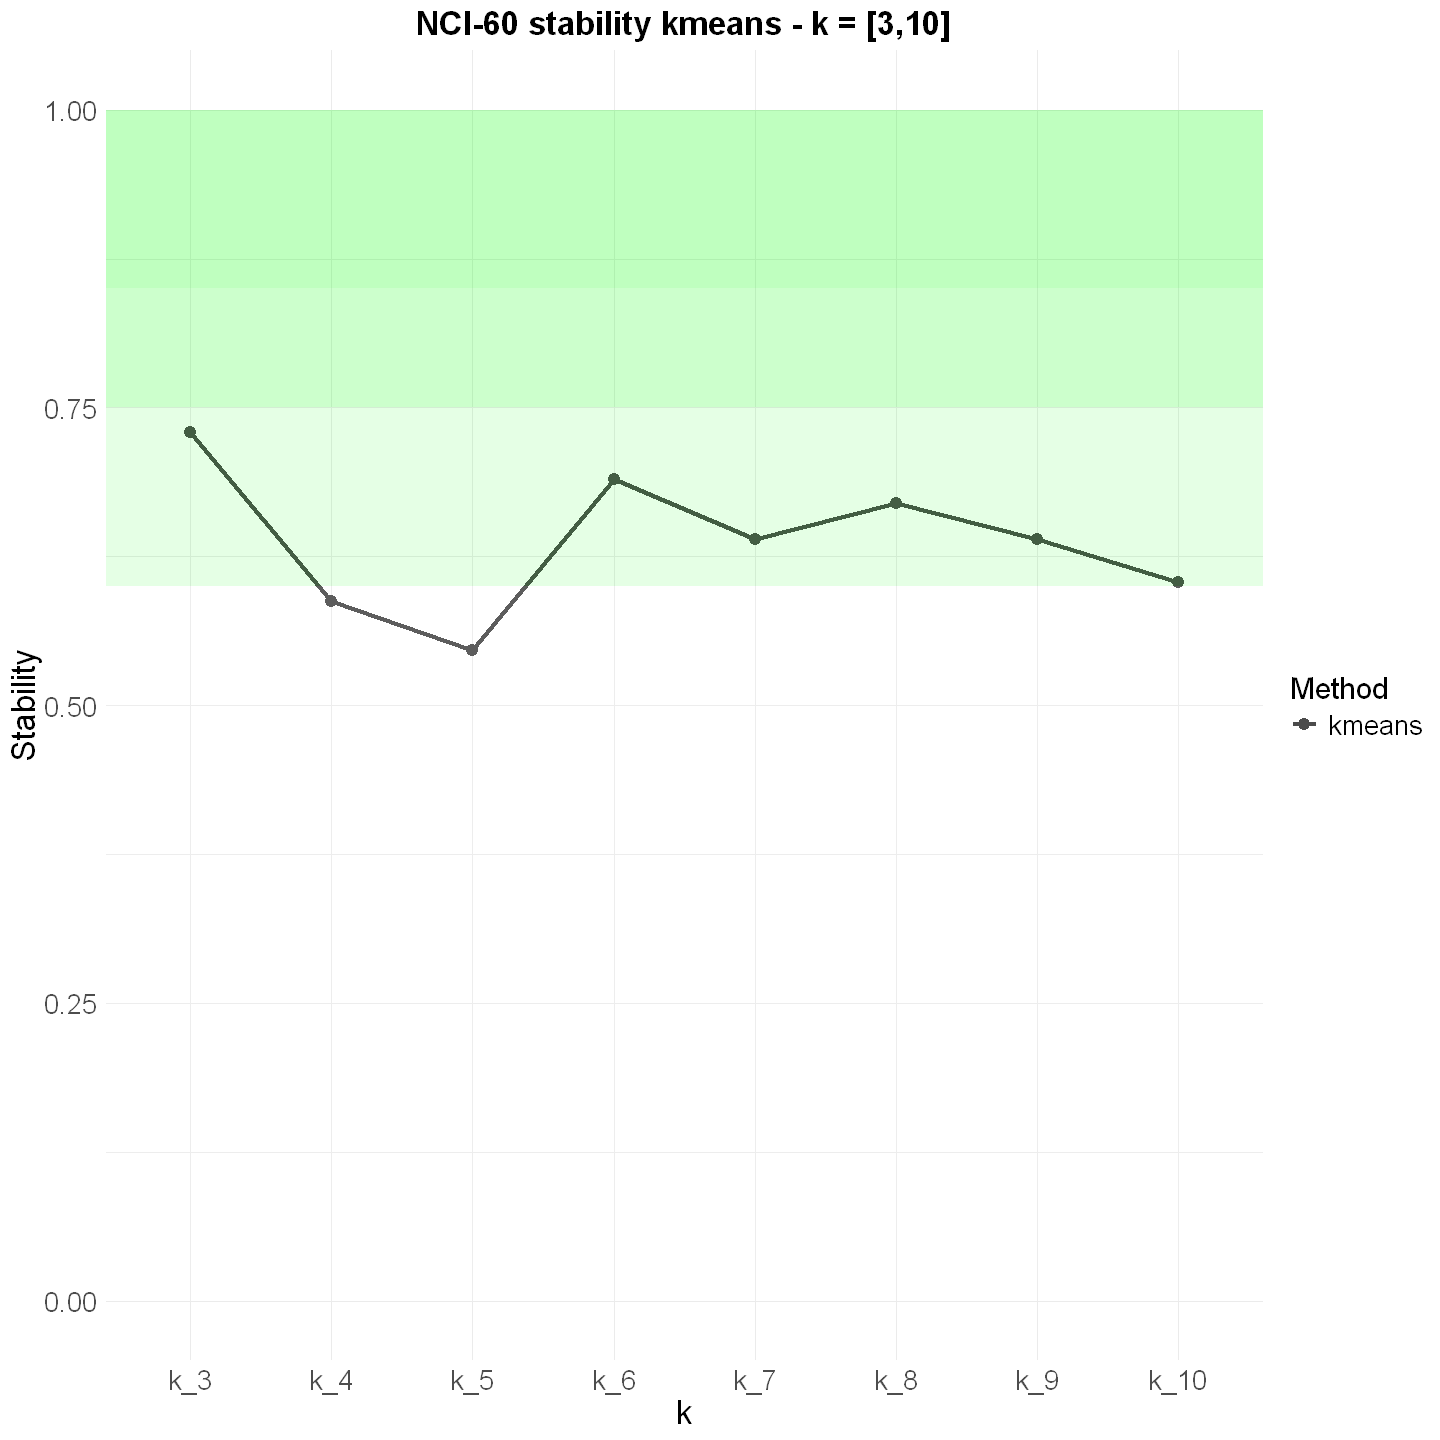

In [15]:
# Color
grayscale_colors <- c("#4B4B4B", "#1E90FF", "black", "darkgray", "gray", "lightgray", "white")

p <- ggplot(stab_melt, aes(x = variable, y = value, color = Method, group = Method)) +
     geom_point(size = 3) +
     geom_line(size = 1.2) +
  scale_color_manual(values = grayscale_colors) +
  labs(
    title = paste0('NCI-60 stability ',cbi,' - k = [', k.range[1], ",", k.range[2], ']'),
    x = 'k',
    y = 'Stability'
  ) +
  scale_y_continuous(limits = c(0, 1)) +
  theme_minimal() +
  theme(
    plot.title = element_text(hjust = 0.5, size = 20, face = "bold"),
    legend.position = "right",
    legend.title = element_text(size = 18),
    legend.text = element_text(size = 16),
    axis.title.x = element_text(size = 20),
    axis.title.y = element_text(size = 20),
    axis.text = element_text(size = 16)
  )

p + 
  annotate("rect", xmin = -Inf, xmax = Inf, ymin = 0.85, ymax = 1, alpha = 0.25, fill = "green") +
  annotate("rect", xmin = -Inf, xmax = Inf, ymin = 0.75, ymax = 0.85, alpha = 0.2, fill = "green") +
  annotate("rect", xmin = -Inf, xmax = Inf, ymin = 0.6, ymax = 0.75, alpha = 0.1, fill = "green") +
  annotate("rect", xmin = -Inf, xmax = Inf, ymin = 0, ymax = 0.6, alpha = 0.1, fill = "white")

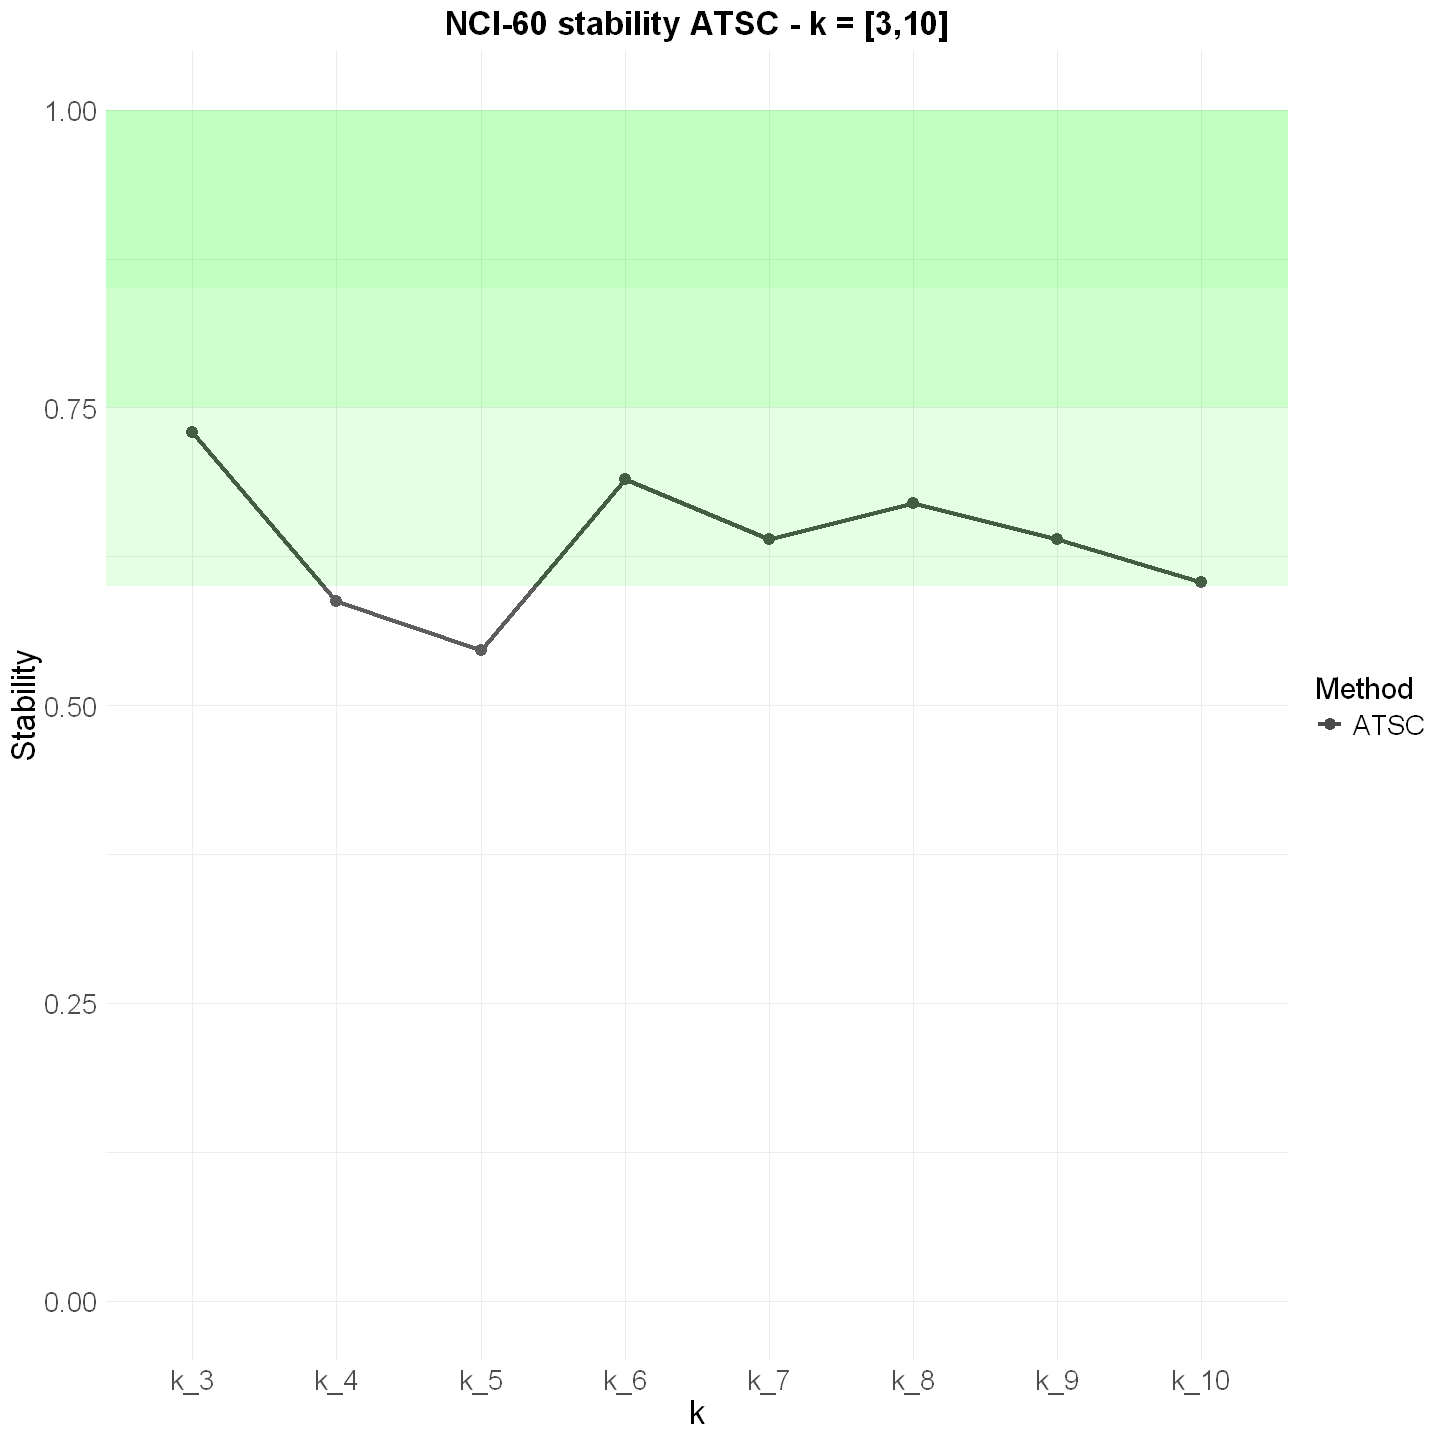

In [16]:
# Stab ATSC
p <- ggplot(stab_ATSC_melt, aes(x = variable, y = value, color = Method, group = Method)) +
    geom_point(size = 3) +
     geom_line(size = 1.2) +
  scale_color_manual(values = grayscale_colors) +
  labs(
    title = paste0('NCI-60 stability ATSC - k = [', k.range[1], ",", k.range[2], ']'),
    x = 'k',
    y = 'Stability'
  ) +
  scale_y_continuous(limits = c(0, 1)) +
  theme_minimal() +
  theme(
    plot.title = element_text(hjust = 0.5, size = 20, face = "bold"),
    legend.position = "right",
    legend.title = element_text(size = 18),
    legend.text = element_text(size = 16),
    axis.title.x = element_text(size = 20),
    axis.title.y = element_text(size = 20),
    axis.text = element_text(size = 16)
  )

p + 
  annotate("rect", xmin = -Inf, xmax = Inf, ymin = 0.85, ymax = 1, alpha = 0.25, fill = "green") +
  annotate("rect", xmin = -Inf, xmax = Inf, ymin = 0.75, ymax = 0.85, alpha = 0.2, fill = "green") +
  annotate("rect", xmin = -Inf, xmax = Inf, ymin = 0.6, ymax = 0.75, alpha = 0.1, fill = "green") +
  annotate("rect", xmin = -Inf, xmax = Inf, ymin = 0, ymax = 0.6, alpha = 0.1, fill = "white")

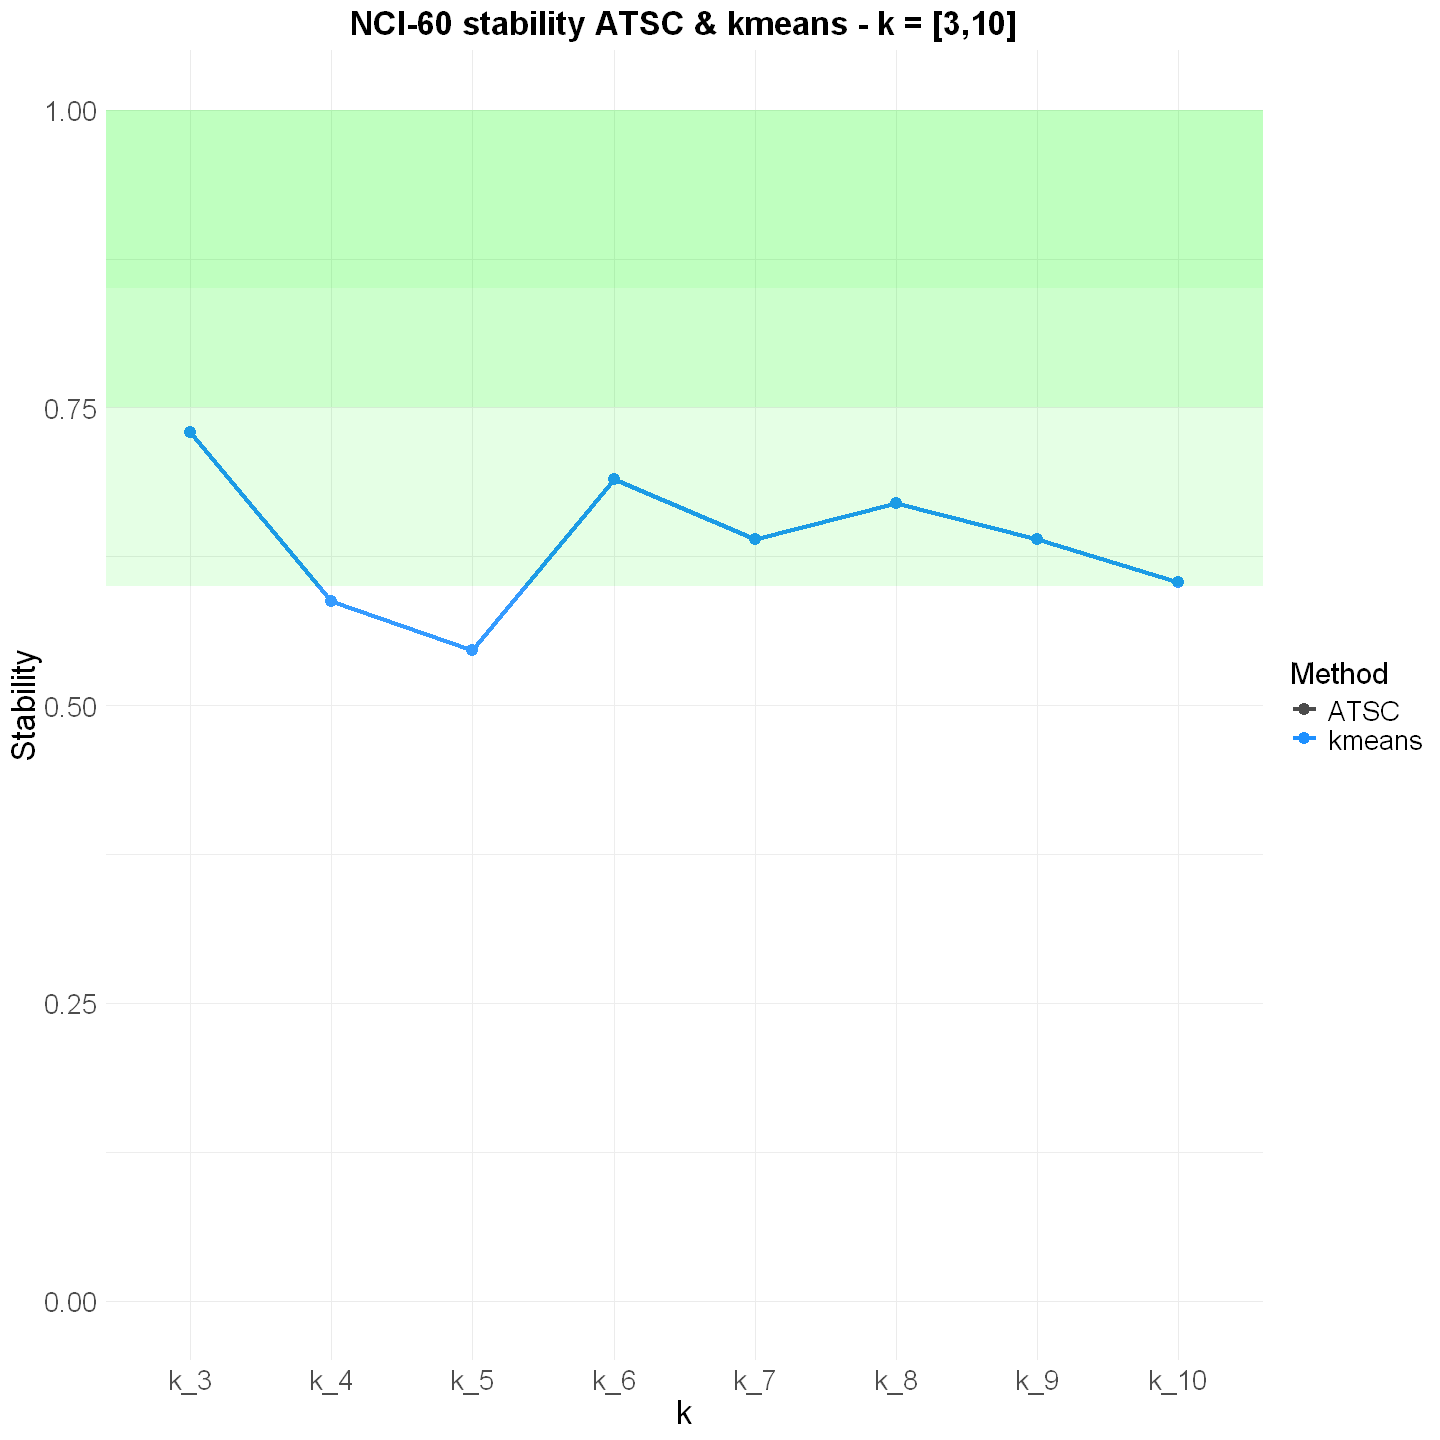

In [17]:
all_stab = rbind(stab_ATSC_melt, stab_melt)
p <- ggplot(all_stab, aes(x = variable, y = value, color = Method, group = Method)) +
    geom_point(size = 3) +
     geom_line(size = 1.2) +
  scale_color_manual(values = grayscale_colors) +
  labs(
    title = paste0('NCI-60 stability ATSC & ', cbi, ' - k = [', k.range[1], ",", k.range[2], ']'),
    x = 'k',
    y = 'Stability'
  ) +
  scale_y_continuous(limits = c(0, 1)) +
  theme_minimal() +
  theme(
    plot.title = element_text(hjust = 0.5, size = 20, face = "bold"),
    legend.position = "right",
    legend.title = element_text(size = 18),
    legend.text = element_text(size = 16),
    axis.title.x = element_text(size = 20),
    axis.title.y = element_text(size = 20),
    axis.text = element_text(size = 16)
  )

p + 
  annotate("rect", xmin = -Inf, xmax = Inf, ymin = 0.85, ymax = 1, alpha = 0.25, fill = "green") +
  annotate("rect", xmin = -Inf, xmax = Inf, ymin = 0.75, ymax = 0.85, alpha = 0.2, fill = "green") +
  annotate("rect", xmin = -Inf, xmax = Inf, ymin = 0.6, ymax = 0.75, alpha = 0.1, fill = "green") +
  annotate("rect", xmin = -Inf, xmax = Inf, ymin = 0, ymax = 0.6, alpha = 0.1, fill = "white")

Quality calculation with $k \in [3,10]$ and `rskc`.

## Quality plotting <a class="anchor" id="evaluomeR_qual_plot"></a>

Quality plot

In [18]:
qual = r_atsc$qual
rownames(qual) = c(paste0("qual_", cbi))
qual$Metric = rownames(qual)
qual$Method = cbi
qual_melt = melt(qual, id.vars = c("Metric", "Method"))

qual_ATSC = r_atsc$qual_ATSC
rownames(qual_ATSC) = c(paste0("qual_", "ATSC"))
qual_ATSC$Metric = rownames(qual_ATSC)
qual_ATSC$Method = "ATSC"
qual_ATSC_melt = melt(qual_ATSC, id.vars = c("Metric", "Method"))

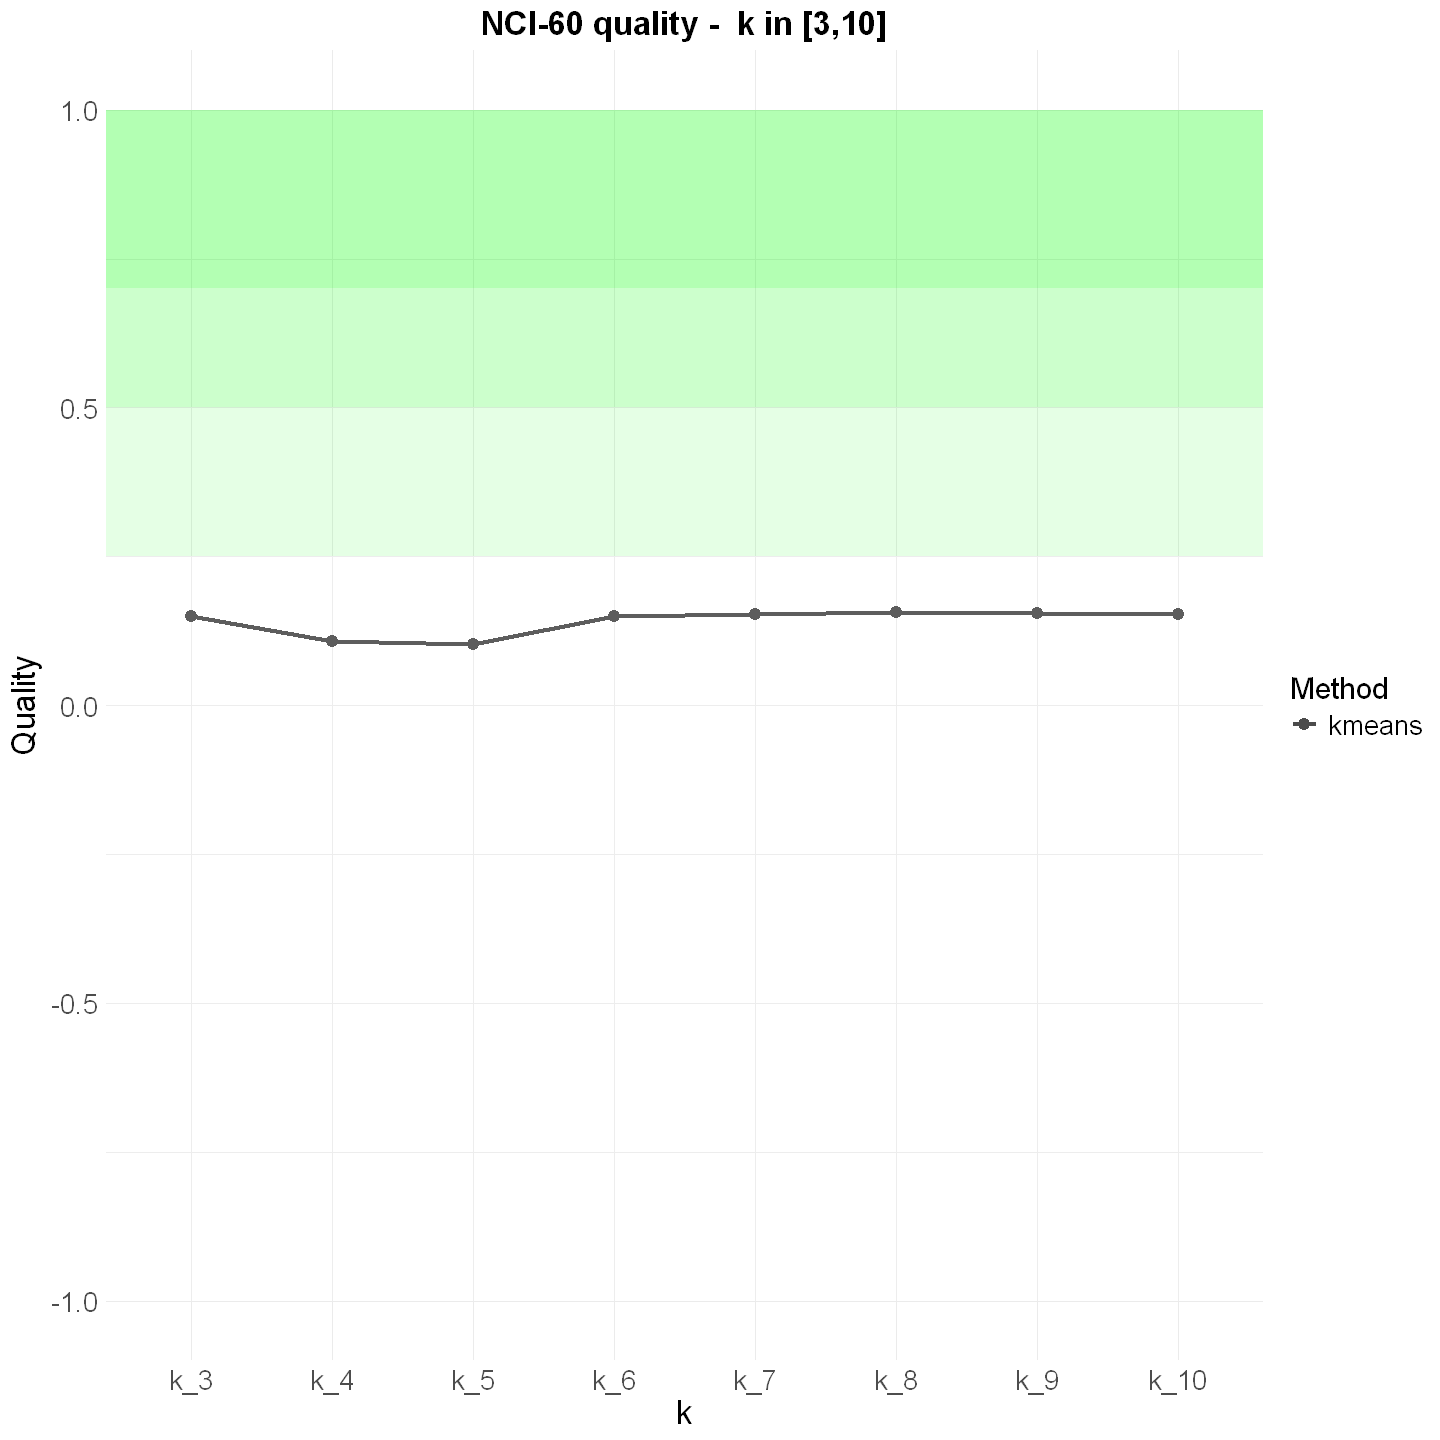

In [19]:

p <- ggplot(qual_melt, aes(x = variable, y = value, color = Method, group = Method)) +
     geom_point(size = 3) +
     geom_line(size = 1.2) +
  scale_color_manual(values = grayscale_colors) +
  labs(
    title = paste0('NCI-60 quality -  k in [', k.range[1], ",", k.range[2], ']'),
    x = 'k',
    y = 'Quality'
  ) +
  scale_y_continuous(limits = c(-1, 1)) +
  theme_minimal() +
  theme(
    plot.title = element_text(hjust = 0.5, size = 20, face = "bold"),
    legend.position = "right",
    legend.title = element_text(size = 18),
    legend.text = element_text(size = 16),
    axis.title.x = element_text(size = 20),
    axis.title.y = element_text(size = 20),
    axis.text = element_text(size = 16)
  )

p + 
  annotate("rect", xmin = -Inf, xmax = Inf, ymin = 0.7, ymax = 1, alpha = 0.3, fill = "green") +
  annotate("rect", xmin = -Inf, xmax = Inf, ymin = 0.5, ymax = 0.7, alpha = 0.2, fill = "green") +
  annotate("rect", xmin = -Inf, xmax = Inf, ymin = 0.25, ymax = 0.5, alpha = 0.1, fill = "green") +
  annotate("rect", xmin = -Inf, xmax = Inf, ymin = -1, ymax = 0.25, alpha = 0.1, fill = "white")

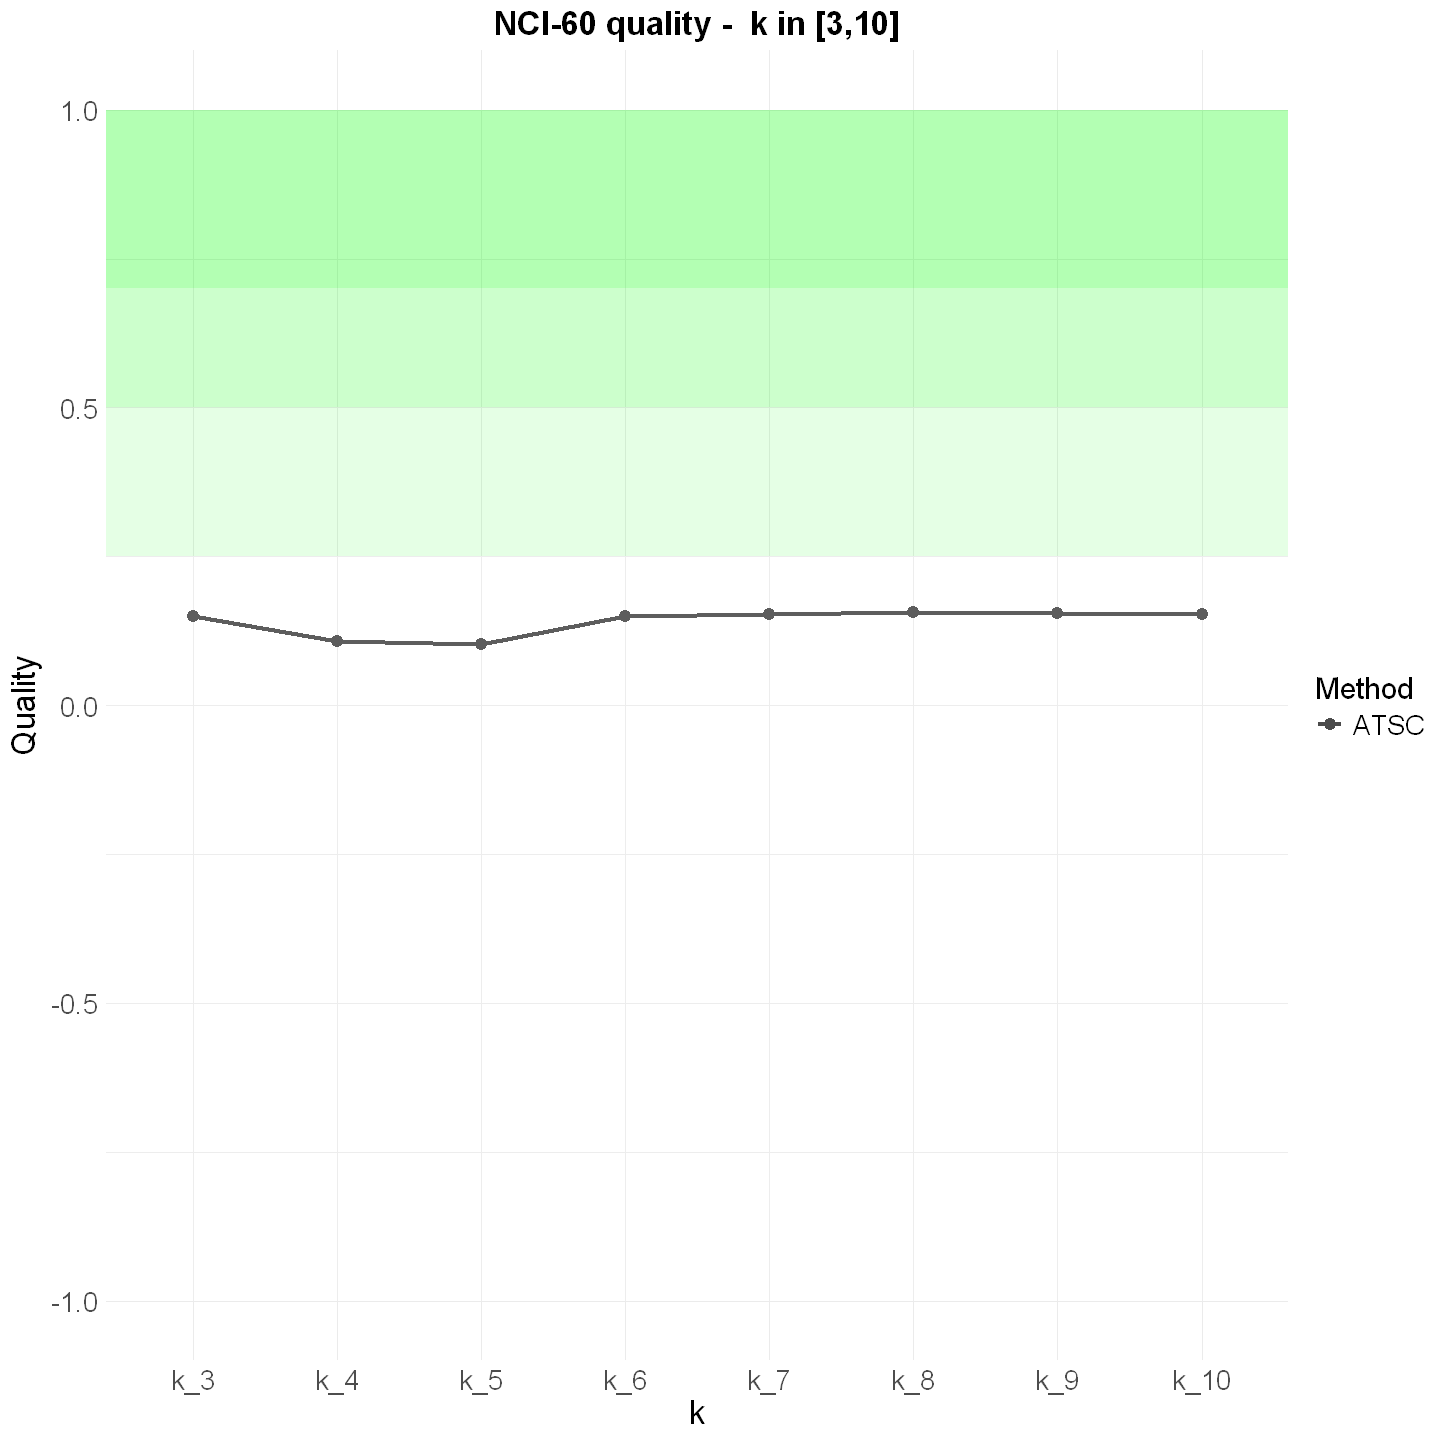

In [20]:
p <- ggplot(qual_ATSC_melt, aes(x = variable, y = value, color = Method, group = Method)) +
     geom_point(size = 3) +
     geom_line(size = 1.2) +
  scale_color_manual(values = grayscale_colors) +
  labs(
    title = paste0('NCI-60 quality -  k in [', k.range[1], ",", k.range[2], ']'),
    x = 'k',
    y = 'Quality'
  ) +
  scale_y_continuous(limits = c(-1, 1)) +
  theme_minimal() +
  theme(
    plot.title = element_text(hjust = 0.5, size = 20, face = "bold"),
    legend.position = "right",
    legend.title = element_text(size = 18),
    legend.text = element_text(size = 16),
    axis.title.x = element_text(size = 20),
    axis.title.y = element_text(size = 20),
    axis.text = element_text(size = 16)
  )

p + 
  annotate("rect", xmin = -Inf, xmax = Inf, ymin = 0.7, ymax = 1, alpha = 0.3, fill = "green") +
  annotate("rect", xmin = -Inf, xmax = Inf, ymin = 0.5, ymax = 0.7, alpha = 0.2, fill = "green") +
  annotate("rect", xmin = -Inf, xmax = Inf, ymin = 0.25, ymax = 0.5, alpha = 0.1, fill = "green") +
  annotate("rect", xmin = -Inf, xmax = Inf, ymin = -1, ymax = 0.25, alpha = 0.1, fill = "white")

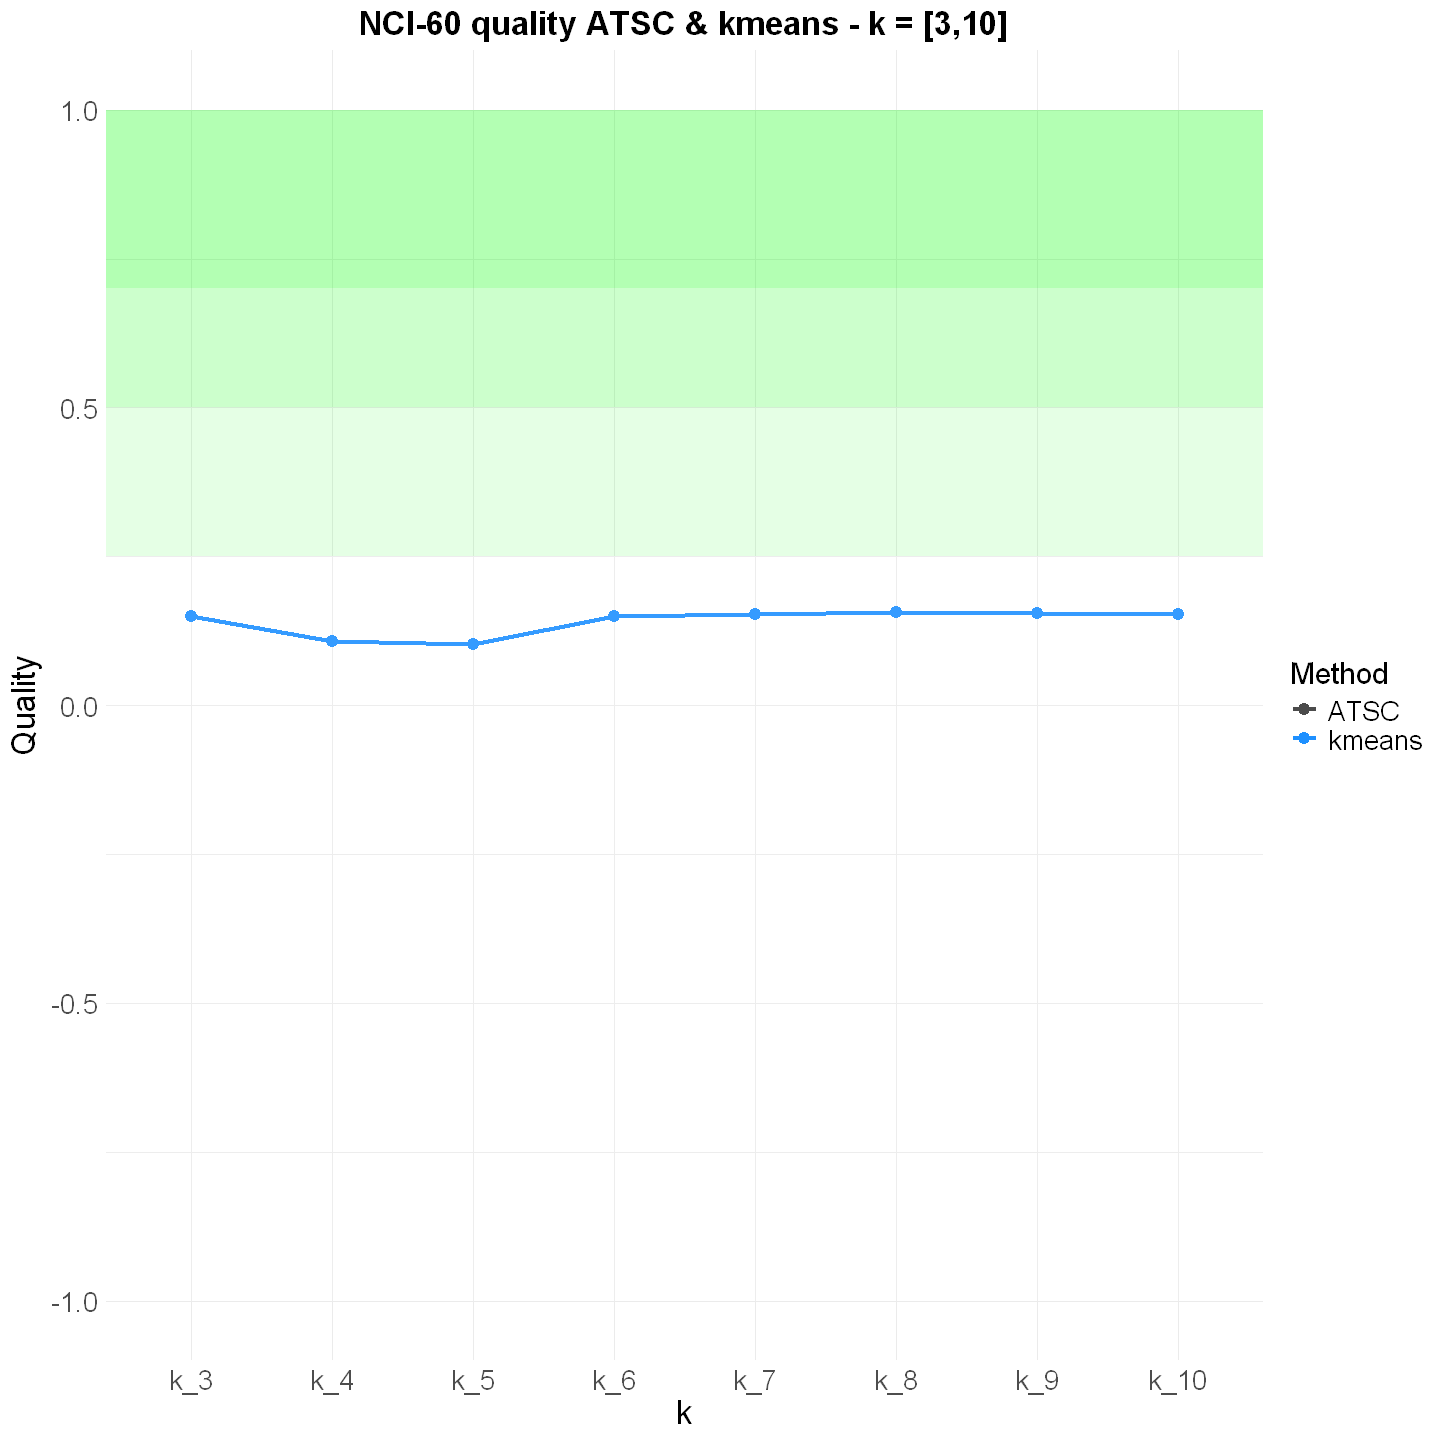

In [21]:
all_qual = rbind(qual_ATSC_melt, qual_melt)
p <- ggplot(all_qual, aes(x = variable, y = value, color = Method, group = Method)) +
     geom_point(size = 3) +
     geom_line(size = 1.2) +
  scale_color_manual(values = grayscale_colors) +
  labs(
    title = paste0('NCI-60 quality ATSC & ', cbi, ' - k = [', k.range[1], ",", k.range[2], ']'),
    x = 'k',
    y = 'Quality'
  ) +
  scale_y_continuous(limits = c(-1, 1)) +
  theme_minimal() +
  theme(
    plot.title = element_text(hjust = 0.5, size = 20, face = "bold"),
    legend.position = "right",
    legend.title = element_text(size = 18),
    legend.text = element_text(size = 16),
    axis.title.x = element_text(size = 20),
    axis.title.y = element_text(size = 20),
    axis.text = element_text(size = 16)
  )

p + 
  annotate("rect", xmin = -Inf, xmax = Inf, ymin = 0.7, ymax = 1, alpha = 0.3, fill = "green") +
  annotate("rect", xmin = -Inf, xmax = Inf, ymin = 0.5, ymax = 0.7, alpha = 0.2, fill = "green") +
  annotate("rect", xmin = -Inf, xmax = Inf, ymin = 0.25, ymax = 0.5, alpha = 0.1, fill = "green") +
  annotate("rect", xmin = -Inf, xmax = Inf, ymin = -1, ymax = 0.25, alpha = 0.1, fill = "white")

Determining the optimal $k$ given the stabilities and qualities in `stab_range` and `qual_range` objects:

In [22]:

print(paste0("Stabilities and qualities per k with '", cbi, "' as clustering method"))
stab
qual
print(paste0("Stabily in k=", r_atsc$optimalK,": ", stab[paste0("k_",r_atsc$optimalK)]))
print(paste0("Quality in k=", r_atsc$optimalk,": ", qual[paste0("k_",r_atsc$optimalK)]))

[1] "Stabilities and qualities per k with 'kmeans' as clustering method"


,k_3,k_4,k_5,k_6,k_7,k_8,k_9,k_10,Metric,Method
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
stab_kmeans,0.7292307,0.5878163,0.5464581,0.689701,0.6398981,0.6699727,0.639195,0.6031684,stab_kmeans,kmeans


,k_3,k_4,k_5,k_6,k_7,k_8,k_9,k_10,Metric,Method
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
qual_kmeans,0.1502642,0.107444,0.1025745,0.1496112,0.1538648,0.1571863,0.1546125,0.1531244,qual_kmeans,kmeans


[1] "Stabily in k=8: 0.669972700910201"
[1] "Quality in k=: 0.157186259501016"


In [23]:

print(paste0("Stabilities and qualities per k with 'ATSC' as clustering method"))
stab_ATSC
qual_ATSC
print(paste0("Stabily in k=", r_atsc$optimalK_ATSC,": ", stab_ATSC[paste0("k_",r_atsc$optimalK_ATSC)]))
print(paste0("Quality in k=", r_atsc$optimalk_ATSC,": ", qual_ATSC[paste0("k_",r_atsc$optimalK_ATSC)]))

[1] "Stabilities and qualities per k with 'ATSC' as clustering method"


,k_3,k_4,k_5,k_6,k_7,k_8,k_9,k_10,Metric,Method
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
stab_ATSC,0.7292307,0.5878163,0.5464581,0.689701,0.6398981,0.6699727,0.639195,0.6031684,stab_ATSC,ATSC


,k_3,k_4,k_5,k_6,k_7,k_8,k_9,k_10,Metric,Method
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
qual_ATSC,0.1502642,0.107444,0.1025745,0.1496112,0.1538648,0.1571863,0.1546125,0.1531244,qual_ATSC,ATSC


[1] "Stabily in k=8: 0.669972700910201"
[1] "Quality in k=: 0.157186259501016"


# Clusters

In [24]:
# Internal method used to group individuals per cluster
individuals_per_cluster = function(qualityResult) {
  qual_df = as.data.frame(assay(qualityResult))


  cluster_pos_str = as.character(unlist(qual_df["Cluster_position"]))
  cluster_labels_str = as.character(unlist(qual_df["Cluster_labels"]))

  cluster_pos = as.list(strsplit(cluster_pos_str, ",")[[1]])
  cluster_labels = as.list(strsplit(cluster_labels_str, ",")[[1]])

  individuals_in_cluster = as.data.frame(cbind(cluster_labels, cluster_pos))
  colnames(individuals_in_cluster) = c("Individual", "Cluster")

  return(individuals_in_cluster)
}

In [25]:
dataset = r_atsc$trimmmedDataset
qual_range = qualityRange(data=dataset, k.range=k.range, 
                            all_metrics=TRUE, seed=seed,
                            cbi=cbi)
optimal_k = r_atsc$optimalK_ATSC
cluster_individuals = individuals_per_cluster(assay(qual_range[paste0("k_",optimal_k)]))
print(paste0("CBI: ", cbi, " - k: ", optimal_k))
for (cluster_i in 1:optimal_k) {
    ind_in_cluster = paste(unlist(cluster_individuals[cluster_individuals$Cluster == cluster_i, ]["Individual"]), collapse = ",")
    print(paste("Cluster", cluster_i, ":", ind_in_cluster))
    print("")
}



Data loaded.
Number of rows: 61
Number of columns: 201



Processing all metrics, 'merge', in dataframe (200)

	Calculation of k = 3

	Calculation of k = 4

	Calculation of k = 5

	Calculation of k = 6

	Calculation of k = 7

	Calculation of k = 8

	Calculation of k = 9

	Calculation of k = 10



[1] "CBI: kmeans - k: 8"
[1] "Cluster 1 : BREAST,NSCLC,RENAL,OVARIAN,MELANOMA,OVARIAN,NSCLC,NSCLC"
[1] ""
[1] "Cluster 2 : CNS,CNS,CNS,RENAL,BREAST,CNS,CNS,BREAST,NSCLC,NSCLC"
[1] ""
[1] "Cluster 3 : MCF7A-repro,BREAST,MCF7D-repro,BREAST"
[1] ""
[1] "Cluster 4 : RENAL,RENAL,RENAL,RENAL,RENAL,RENAL,RENAL"
[1] ""
[1] "Cluster 5 : K562B-repro,K562A-repro,LEUKEMIA,LEUKEMIA,LEUKEMIA,LEUKEMIA,LEUKEMIA"
[1] ""
[1] "Cluster 6 : MELANOMA,BREAST,BREAST,MELANOMA,MELANOMA,MELANOMA,MELANOMA,MELANOMA,MELANOMA"
[1] ""
[1] "Cluster 7 : COLON,COLON,COLON,COLON,COLON,COLON,COLON"
[1] ""
[1] "Cluster 8 : OVARIAN,OVARIAN,OVARIAN,OVARIAN,NSCLC,NSCLC,NSCLC,LEUKEMIA,NSCLC"
[1] ""


# PCA <a class="anchor" id="pca"></a>
We employ Principal Component Analysis (PCA) as a dimensionality reduction technique to facilitate the visualization of clusters within our dataset. PCA allow us to transform the original high-dimensional data into a lower-dimensional space, while preserving as much of the variability as possible.

In [26]:
dataset["Cluster"] = as.factor(as.numeric(cluster_individuals$Cluster))
if (pca_suitability$pca_suitable) {
    pca_df = dataset
} else {
    pca_matrix = dataset %>% select(-Cluster)
    r_pca = evaluomeR::performPCA(dataset = pca_matrix)
    pca_df = r_pca$dataset_ncp
    pca_df$Cluster <- as.factor(dataset$Cluster)
    pca_df$Description <- dataset$Description
}
head(pca_df)

Parameter 'npc' is null. Computing number of factors automatically:

Number of factors, 'ncp' used is: 35



,Description,Dim.1,Dim.2,Dim.3,Dim.4,Dim.5,Dim.6,Dim.7,Dim.8,Dim.9,⋯,Dim.27,Dim.28,Dim.29,Dim.30,Dim.31,Dim.32,Dim.33,Dim.34,Dim.35,Cluster
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
V1,CNS,6.097478,-0.1647514,-2.3625462,-3.7853640,0.9176837,6.4919889,1.4840796,0.2589460,3.4998415,⋯,0.6858008,-1.0552969,-0.6967309,-1.8748524,0.9264463,-0.04483378,0.7213328,-0.18457639,0.3644274,2
V2,CNS,5.977258,-1.4124431,-2.6126761,-3.0120919,0.6265247,7.5868320,2.2478333,-0.1085869,3.6182820,⋯,1.2183512,-0.9289955,-0.2166457,0.7686252,-0.9808568,-0.86641394,1.0211971,-0.32449799,0.4670006,2
V3,CNS,8.099173,0.6272192,-2.5754395,-0.7765312,4.2457457,2.0342516,3.1462687,-0.1289517,0.3664121,⋯,-1.2577831,0.5822799,0.4963585,-1.2001106,1.2801710,-0.44156235,0.6244619,-0.53321457,-0.8435209,2
V4,RENAL,12.058369,-2.0675882,-0.9389058,-4.8318299,7.9733869,0.9990644,-0.8670394,-3.7441178,0.2475365,⋯,1.8721395,1.3793647,0.4133163,2.5161183,-0.3965475,0.48625665,-1.9901873,0.08974292,0.6575116,2
V5,BREAST,13.947443,-1.1437883,-4.0425461,-3.0270261,6.2188670,-7.3679187,-0.8251566,-3.9419799,-1.0727189,⋯,-0.5671506,0.3484836,0.9523690,-0.2816908,-1.1907146,-0.36240900,1.1290450,-0.58478239,-0.5216343,2
V6,CNS,8.213053,-2.0996348,-3.9458410,-3.5244792,3.5893639,-2.9162137,-0.2791665,-3.1057802,-1.6023299,⋯,-2.1052186,-1.8980170,-0.8604657,-2.3398188,-1.0171413,0.47675312,0.1367769,1.46226006,2.0742978,2


Warning message:
"The following aesthetics were dropped during statistical transformation: label.
ℹ This can happen when ggplot fails to infer the correct grouping structure in
  the data.
ℹ Did you forget to specify a `group` aesthetic or to convert a numerical
  variable into a factor?"
Warning message:
"ggrepel: 9 unlabeled data points (too many overlaps). Consider increasing max.overlaps"


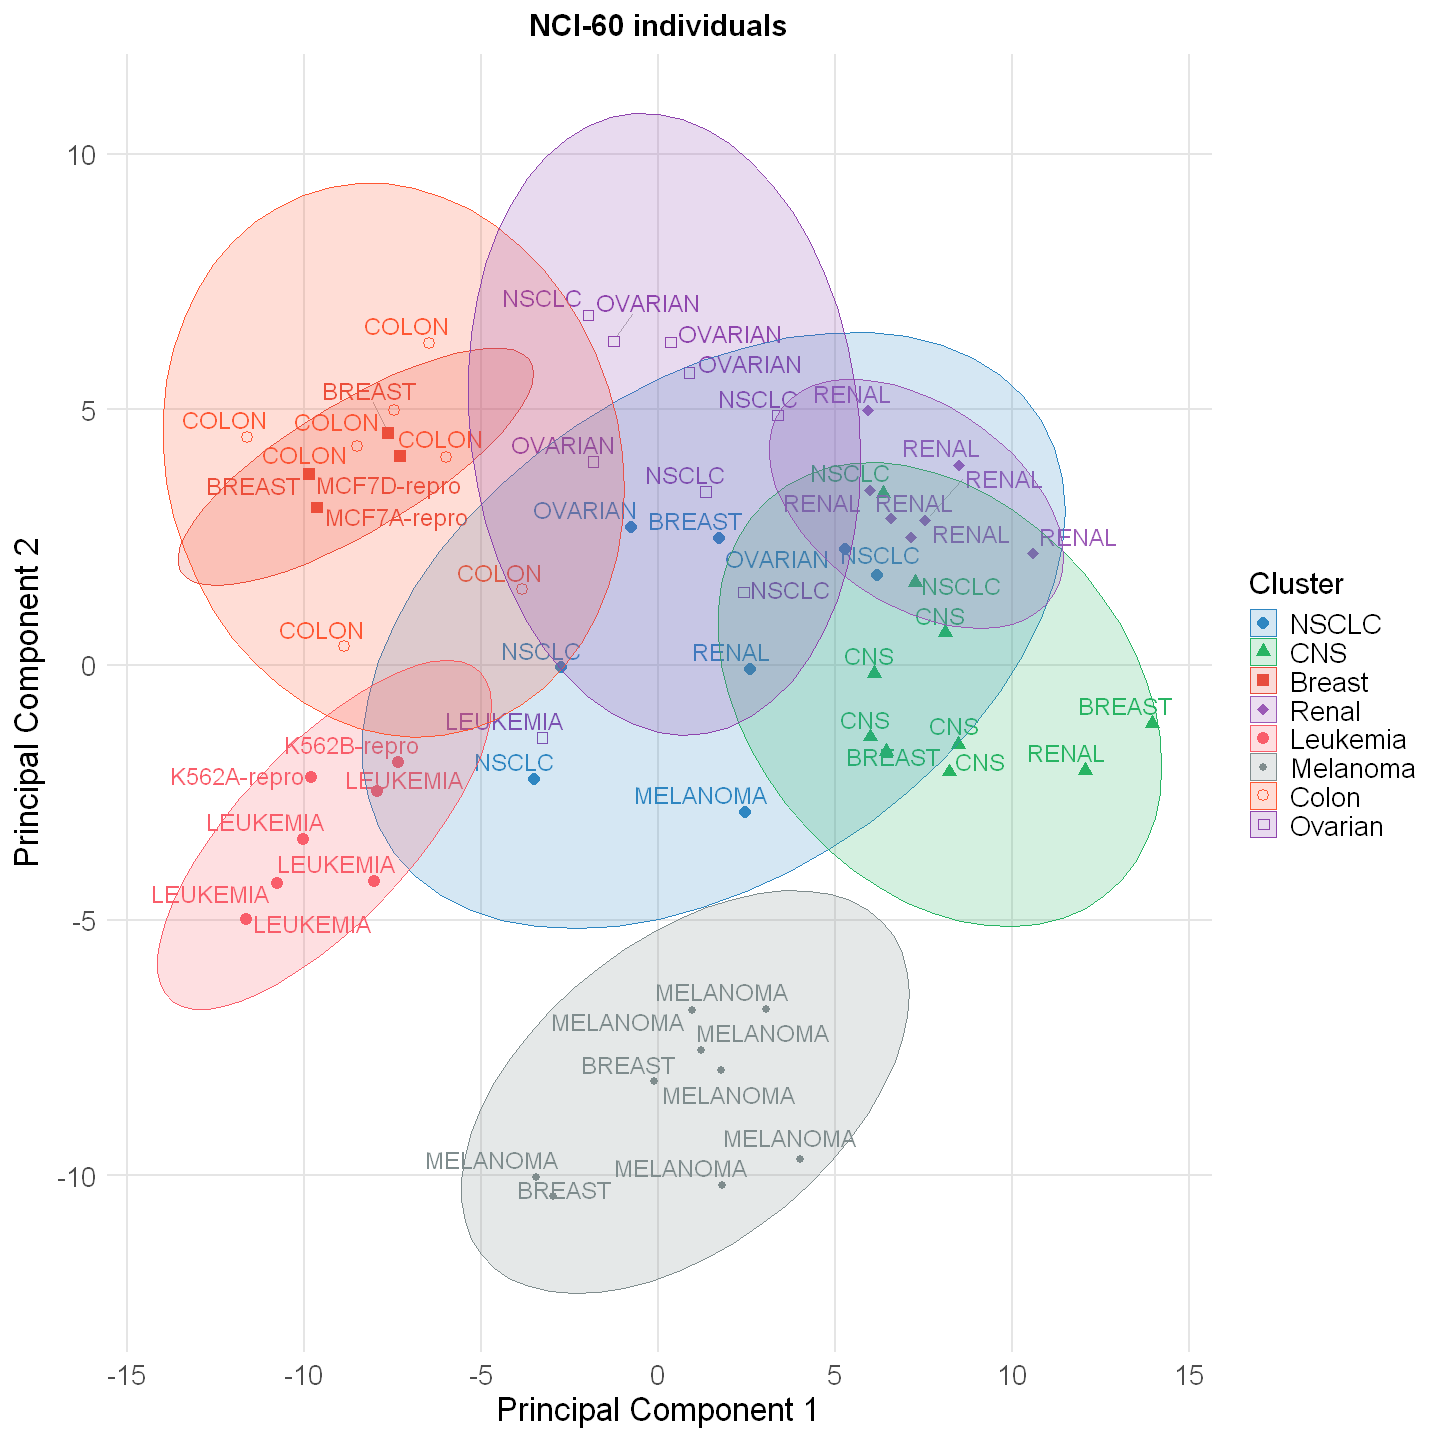

In [28]:
options(repr.plot.width=12, repr.plot.height=12)
custom_colors = custom_colors <- c("#2E86C1", "#28B463", "#E74C3C", "#9B59B6", "#f95d6a", 
                                    "#7F8C8D", "#FF5733", "#8E44AD", "#003f5c", "#ffa600")

cluster_shapes =  c(16, 17, 15, 18, 19, 20, 21, 22, 23, 24)
if (alpha == 0) {
    cluster_labels = c("NSCLC", "CNS", "Breast", "Renal", "Leukemia", "Melanoma", "Colon", "Ovarian")
}
if (alpha == 0.1) {
    cluster_labels = c("Melanoma", "CNS", "Leukemia", "NSCLC, Renal, Ovarian", "Breast, Colon")
}


ggplot(pca_df, aes(x = Dim.1, y = Dim.2, shape = Cluster, color = Cluster, label = Description)) +
  geom_point(size = 3) +
  geom_text_repel(
    vjust = 1,
    hjust = 1,
    size = 5,
    show.legend = FALSE,
    point.padding = 0.4,
    box.padding = 0.25,
    max.overlaps = 10,
    segment.color = "grey70",
    segment.size = 0.2
  ) +
  stat_ellipse(aes(fill = Cluster), level = 0.95, alpha = 0.2, geom = "polygon") +
  labs(
    title = "NCI-60 individuals",
    x = "Principal Component 1",
    y = "Principal Component 2"
  ) +
  scale_shape_manual(values = cluster_shapes, labels = cluster_labels) +
  scale_color_manual(values = custom_colors, labels = cluster_labels)  +
  scale_fill_manual(values = custom_colors, labels = cluster_labels)   +
  theme_minimal(base_size = 15) +
  theme(
    plot.title = element_text(hjust = 0.5, size = 18, face = "bold"),
    axis.title.x = element_text(size = 20),
    axis.title.y = element_text(size = 20),
    axis.text = element_text(size = 16),
    legend.position = "right",
    legend.title = element_text(size = 18),
    legend.text = element_text(size = 16),
    panel.grid.major = element_line(color = "grey90"),
    panel.grid.minor = element_blank()
  )

# Sensitivity <a class="anchor" id="sensitivity"></a>
In this Section we evaluate the sensitivity of our clustering using the `MLmetrics::Sensitivity` method. Sensitivity, or the true positive rate, measures the ability to correctly identify positive instances within the data. By focusing on sensitivity, we aim to ensure that our model effectively captures the relevant clusters, minimizing the number of false negatives. 

In [ ]:
dataset["Class"] = dataset["Description"]
head(dataset)[, c("Description", "Class")]

In [ ]:
if (alpha = 0) {
level_mapping <- c("NSCLC" = 1, "CNS" = 2, "BREAST" = 3,
                 "MCF7A-repro" = 3, "MCF7D-repro" = 3, "RENAL" = 4, 
                 "LEUKEMIA" = 5, "K562B-repro" = 5, "K562A-repro" = 5, 
                 "MELANOMA" = 6,  "COLON" = 7, "OVARIAN" = 8
                  )
}
if (alpha == 0.05) {
level_mapping <- c("NSCLC" = 2, "CNS" = 2, "BREAST" = 5,
                 "MCF7A-repro" = 5, "MCF7D-repro" = 5, "RENAL" = 4, 
                 "LEUKEMIA" = 3, "K562B-repro" = 3, "K562A-repro" = 3, 
                 "MELANOMA" = 1,  "COLON" = 5, "OVARIAN" = 5
                  )
}
if (alpha == 0.1) {
level_mapping <- c("NSCLC" = 4, "CNS" = 2, "BREAST" = 5,
                 "MCF7A-repro" = 5, "MCF7D-repro" = 5, "RENAL" = 4, 
                 "LEUKEMIA" = 3, "K562B-repro" = 3, "K562A-repro" = 3, 
                 "MELANOMA" = 1,  "COLON" = 5, "OVARIAN" = 4
                  )
}
if (alpha == 0.15) {
level_mapping <- c("NSCLC" = 2, "CNS" = 2, "BREAST" = 3,
                 "MCF7A-repro" = 3, "MCF7D-repro" = 3, "RENAL" = 2, 
                 "LEUKEMIA" = 3, "K562B-repro" = 3, "K562A-repro" = 3, 
                 "MELANOMA" = 1,  "COLON" = 3, "OVARIAN" = 3
                  )
}
if (alpha == 0.2) {
level_mapping <- c("NSCLC" = 3, "CNS" = 3, "BREAST" = 4,
                 "MCF7A-repro" = 4, "MCF7D-repro" = 4, "RENAL" = 3, 
                 "LEUKEMIA" = 2, "K562B-repro" = 2, "K562A-repro" = 2, 
                 "MELANOMA" = 1,  "COLON" = 4, "OVARIAN" = 4
                  )
}
if (alpha == 0.25) { 
level_mapping <- c("NSCLC" = 1, "CNS" = 1, "BREAST" = 3,
                 "MCF7A-repro" = 3, "MCF7D-repro" = 3, "RENAL" = 1, 
                 "LEUKEMIA" = 4, "K562B-repro" = 4, "K562A-repro" = 4, 
                 "MELANOMA" = 2,  "COLON" = 3, "OVARIAN" = 3
                  )
}
map_strings_to_numbers <- function(strings) {
    return(as.numeric(level_mapping[strings]))
}
# Map categories with cluster number
dataset["Class_n"] = lapply(dataset["Class"], map_strings_to_numbers)
# Table of prediction vs actual classification
head(dataset)[, c("Description", "Class", "Cluster", "Class_n")]

In [ ]:
# Getting a vector of prediction vs actual classification
actual = as.factor(as.vector(unlist(dataset["Class_n"])))
predicted <- factor(as.vector(unlist(dataset["Cluster"])))

print("actual")
actual
print("predicted")
predicted

In [ ]:
sens <- MLmetrics::Sensitivity(y_pred = predicted, y_true = actual)
sens = format(round(sens*100, 2), nsmall = 2)
print(paste0("Sensitivity: ", sens, "%"))

# CER <a class="anchor" id="cer"></a>
To assess the overall accuracy of our clustering, we compute the Classification Error Rate (CER) and compare it with the gold standard classification. CER represents the proportion of misclassified instances, thus providing a clear measure of the clustering performance in assigning individuals to the correct clusters.

In [ ]:
cer <- CER(predicted, actual)
cer = format(round(cer*100, 2), nsmall = 2)
print(paste0("CER: ", cer, "%"))